In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from numba import njit
import os


from aeon.utils.numba.general import z_normalise_series_2d

# from aeon.distances import euclidean_distance
# from aeon.distances import dtw_distance
from aeon.distances import get_distance_function

In [2]:
%load_ext autoreload
%autoreload 2

from ksfdtw.distance_measures import (
    usdtw_prime as ksfdtw_usdtw_prime, 
    psdtw_prime_vanilla as psdtw_prime_vanilla, 
    psedd_prime as psedd_prime, 
    psedd_prime_test as psedd_prime_test,
    cut_based_distance as cut_based_distance)
from ksfdtw.utils import precision_at_k

# Import Dataset

In [3]:
# A neat way to load the dataset, but more complicated to use
# data = np.load("../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz")
# data_dict = {key: data[key] for key in data.files}

# A old way to load the dataset
data = np.load(
    "../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz",
    allow_pickle=True,
)
X_train_scaled = data["X_train_scaled"]
X_train_ps = data["X_train_ps"]
X_train_ps_noise = data["X_train_ps_noise"]
y_train = data["y_train"]
X_test_scaled = data["X_test_scaled"]
X_test_ps = data["X_test_ps"]
X_test_ps_noise = data["X_test_ps_noise"]
y_test = data["y_test"]
X_train_cuts = data["X_train_cuts"].tolist()
X_train_ps_cuts = data["X_train_ps_cuts"].tolist()
X_test_cuts = data["X_test_cuts"].tolist()
X_test_ps_cuts = data["X_test_ps_cuts"].tolist()

In [4]:
# X_train_scaled.shape, X_train_ps.shape, X_train_ps_noise.shape

In [5]:
X_train_scaled_norm = z_normalise_series_2d(X_train_scaled)
X_train_ps_norm = z_normalise_series_2d(X_train_ps)
X_train_ps_noise_norm = z_normalise_series_2d(X_train_ps_noise)

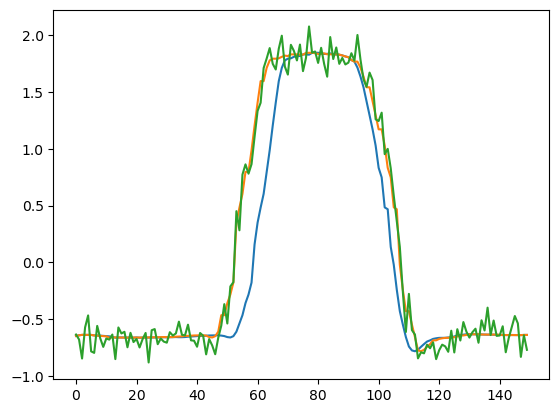

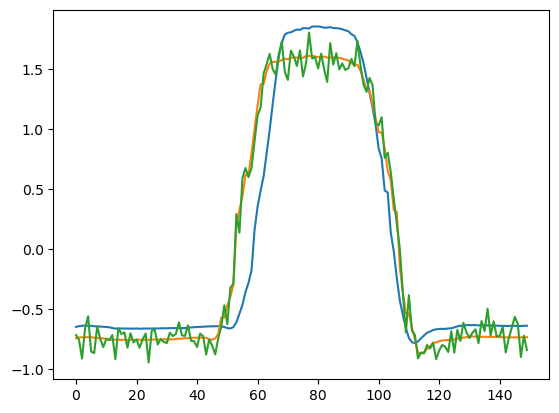

In [6]:
instance_idx = 0
plt.plot(X_train_scaled[instance_idx])
plt.plot(X_train_ps[instance_idx])
plt.plot(X_train_ps_noise[instance_idx])
plt.show()
plt.plot(X_train_scaled_norm[instance_idx])
plt.plot(X_train_ps_norm[instance_idx])
plt.plot(X_train_ps_noise_norm[instance_idx])
plt.show()

# Querying

In [ ]:
# *** Change here 1 ***
# Query set
# query_set = X_train_ps
query_set = X_train_ps_norm
# query_set = X_train_ps_noise
# query_set = X_train_ps_noise_norm


# Target set
# target_set = X_train_scaled
target_set = X_train_scaled_norm
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

In [8]:
# Q = query_set[0]
# C = target_set[0]
# psdtw_prime(Q, C, l=2, P=3, r=0.1)

## Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [9]:
# *** Change here 2 ***
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
# **aeon**
# --------------------- Step 1 ---------------------

# method_name = "dtw"
# method_name = "shape_dtw"
# method_name = "ddtw"
# method_name = "wdtw"
# method_name = "wddtw"
# method_name = "adtw"
# method_name = "erp"
# method_name = "edr"
# method_name = "msm"
# method_name = "twe"
# method_name = "lcss"
# --------------------- Step 2 ---------------------

# dist_func_prime = get_distance_function(method_name)
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

In [10]:
# --------------------- Only Step 1 ---------------------
# *euclidean*
# dist_func = get_distance_function("euclidean")

# *manhattan*
# dist_func = get_distance_function("manhattan")

# *minkowski*
# dist_func = get_distance_function("minkowski")

# *sbd*
# dist_func = get_distance_function("sbd")

In [11]:
# --------------------- Step 1 ---------------------
# *psed*
method_name = "psed"
dist_func_p = lambda Q, C: psdtw_prime_vanilla(Q, C, l=2, P=3, r=0.1, dist_method=0)


# *psdtw*
# method_name = "psdtw"
# dist_func_p = lambda Q, C: psdtw_prime_vanilla(Q, C, l=2, P=3, r=0.1, dist_method=1)
# --------------------- Step 2 ---------------------
# def dist_func(Q, C):
#     dist, _, _ = dist_func_p(Q, C)
#     return dist

In [12]:
# *psedd*
# method_name = "psedd"
# dist_func = lambda Q, C: psedd_prime(Q, C, l=2, P=3, r=0.1)

In [13]:
all_distances = []
all_count_dist_calls = []
all_cuts = []

In [14]:
%%time
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    # *** Change here 3 ***
    # distances = np.array([dist_func(query_set[i], x) for x in target_set])
    
    results = [dist_func_p(query_set[i], x) for x in target_set]
    dist_arr, count_dist_calls_arr, cuts_arr = zip(*results)
    distances = np.array(dist_arr)
    # store per-iteration results
    all_distances.append(distances)
    all_count_dist_calls.append(count_dist_calls_arr)
    all_cuts.append(cuts_arr)

    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
print(
    f"{precision_at_1 / len(query_set):.2f},",
    f"{precision_at_3 / len(query_set):.2f},",
    f"{precision_at_5 / len(query_set):.2f},",
    f"{precision_at_7 / len(query_set):.2f}",
)

0.20, 1.00, 1.00, 1.00
CPU times: user 26.6 s, sys: 261 ms, total: 26.8 s
Wall time: 27.2 s


In [15]:
# *** Change here 4 ***

# Ensure the folder exists
os.makedirs("../results_temp", exist_ok=True)

np.savez(
    "../results_temp/" + method_name + ".npz",
    all_distances=np.array(all_distances, dtype=object),
    all_count_dist_calls=np.array(all_count_dist_calls, dtype=object),
    all_cuts=np.array(all_cuts, dtype=object),
    precision_at_1=precision_at_1 / len(query_set),
    precision_at_3=precision_at_3 / len(query_set),
    precision_at_5=precision_at_5 / len(query_set),
    precision_at_7=precision_at_7 / len(query_set),
)

# Pruning (Only for PSED, and PSDW)
Since PSEDD uses the cut of PSED as input, their "total_count_dist_calls" are the same.

In [16]:
data = np.load("../results_temp/psed.npz", allow_pickle=True)

all_distances = data["all_distances"]
all_count_dist_calls = data["all_count_dist_calls"]
all_cuts = data["all_cuts"]

print("precision@1 =", data["precision_at_1"])

precision@1 = 0.2


In [17]:
# Check total count_dist_calls
total_count_dist_calls = 0
for r in results:
    total_count_dist_calls += r[1]
print(total_count_dist_calls)

8373544


In [18]:
X_train_ps_norm.shape, X_train_ps_noise_norm.shape

((50, 150), (50, 150))

In [19]:
%%time
cut_based_distance(
    X_train_ps_norm[0], X_train_scaled_norm[0], 2, 3, 0.1, 0, results[0][2]
)

0 41 0 37
41 91 37 81
91 150 81 150
CPU times: user 744 ms, sys: 15.1 ms, total: 760 ms
Wall time: 763 ms


68.58544773245782

In [20]:
%%time
psedd_prime_test(X_train_ps_norm[0], X_train_scaled_norm[0], 2, 3, 0.1)

[[  0  40   0  48]
 [ 40 109  48 107]
 [109 150 107 150]]
CPU times: user 1.67 s, sys: 63.1 ms, total: 1.73 s
Wall time: 1.75 s


3.3884497705100824

In [21]:
%%time
psdtw_prime_vanilla(X_train_ps_norm[0], X_train_scaled_norm[0], 2, 3, 0.1, 1)

CPU times: user 11.8 s, sys: 105 ms, total: 11.9 s
Wall time: 12.2 s


(2.616443648118869,
 1790932,
 array([[  0,  44,   0,  44],
        [ 44, 114,  44, 112],
        [114, 150, 112, 150]]))

In [22]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-09-10 17:37:55.177800

